# **Face Recognition with Local Binary Patterns (LBP)** 

In [1]:
%cd face-reco-lbps

/content/face-reco-lbps


### Import Packages

In [2]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2
import os

Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Creating our face detector

In [4]:
def detect_faces(net, image, minConfidence=0.5):
	# grab the dimensions of the image and then construct a blob
	# from it
	(h, w) = image.shape[:2]
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network to obtain the face detections,
	# then initialize a list to store the predicted bounding boxes
	net.setInput(blob)
	detections = net.forward()
	boxes = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > minConfidence:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# update our bounding box results list
			boxes.append((startX, startY, endX, endY))

	# return the face detection bounding boxes
	return boxes

### Loading the CALTECH Faces dataset

In [5]:
def load_face_dataset(inputPath, net, minConfidence=0.5,
	minSamples=15):
	# grab the paths to all images in our input directory, extract
	# the name of the person (i.e., class label) from the directory
	# structure, and count the number of example images we have per
	# face
	imagePaths = list(paths.list_images(inputPath))
	names = [p.split(os.path.sep)[-2] for p in imagePaths]
	(names, counts) = np.unique(names, return_counts=True)
	names = names.tolist()

	# initialize lists to store our extracted faces and associated
	# labels
	faces = []
	labels = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image from disk and extract the name of the person
		# from the subdirectory structure
		image = cv2.imread(imagePath)
		name = imagePath.split(os.path.sep)[-2]

		# only process images that have a sufficient number of
		# examples belonging to the class
		if counts[names.index(name)] < minSamples:
			continue

		# perform face detection
		boxes = detect_faces(net, image, minConfidence)

		# loop over the bounding boxes
		for (startX, startY, endX, endY) in boxes:
			# extract the face ROI, resize it, and convert it to
			# grayscale
			faceROI = image[startY:endY, startX:endX]
			faceROI = cv2.resize(faceROI, (47, 62))
			faceROI = cv2.cvtColor(faceROI, cv2.COLOR_BGR2GRAY)

			# update our faces and labels lists
			faces.append(faceROI)
			labels.append(name)

	# convert our faces and labels lists to NumPy arrays
	faces = np.array(faces)
	labels = np.array(labels)

	# return a 2-tuple of the faces and labels
	return (faces, labels)

### Implementing Local Binary Patterns for face recognition

In [6]:
args = {
	"input": "caltech_faces",
	"face": "face_detector",
    "confidence": 0.5,
}

In [7]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] loading face detector model...


In [8]:
# load the CALTECH faces dataset
print("[INFO] loading dataset...")
(faces, labels) = load_face_dataset(args["input"], net,
	minConfidence=0.5, minSamples=20)
print("[INFO] {} images in dataset".format(len(faces)))

# encode the string labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# construct our training and testing split
(trainX, testX, trainY, testY) = train_test_split(faces,
	labels, test_size=0.25, stratify=labels, random_state=42)

[INFO] loading dataset...
[INFO] 397 images in dataset


In [9]:
# train our LBP face recognizer
print("[INFO] training face recognizer...")
recognizer = cv2.face.LBPHFaceRecognizer_create(
	radius=2, neighbors=16, grid_x=8, grid_y=8)
start = time.time()
recognizer.train(trainX, trainY)
end = time.time()
print("[INFO] training took {:.4f} seconds".format(end - start))

[INFO] training face recognizer...
[INFO] training took 3.9745 seconds


In [10]:
# initialize the list of predictions and confidence scores
print("[INFO] gathering predictions...")
predictions = []
confidence = []
start = time.time()

# loop over the test data
for i in range(0, len(testX)):
	# classify the face and update the list of predictions and
	# confidence scores
	(prediction, conf) = recognizer.predict(testX[i])
	predictions.append(prediction)
	confidence.append(conf)

# measure how long making predictions took
end = time.time()
print("[INFO] inference took {:.4f} seconds".format(end - start))

# show the classification report
print(classification_report(testY, predictions,
	target_names=le.classes_))

[INFO] gathering predictions...
[INFO] inference took 155.9266 seconds
              precision    recall  f1-score   support

     abraham       1.00      0.80      0.89         5
       allen       0.89      1.00      0.94         8
      carmen       1.00      1.00      1.00         5
      conrad       0.75      1.00      0.86         6
     cynthia       1.00      0.80      0.89         5
     darrell       1.00      1.00      1.00         5
       frank       1.00      1.00      1.00         5
      gloria       0.83      1.00      0.91         5
     jacques       1.00      0.83      0.91         6
        judy       1.00      1.00      1.00         5
       julie       1.00      1.00      1.00         5
     kenneth       1.00      0.83      0.91         6
         mae       1.00      1.00      1.00         5
     raymond       0.86      1.00      0.92         6
        rick       1.00      1.00      1.00         6
      sherry       1.00      0.83      0.91         6
     tiffa

[INFO] prediction: frank, actual: frank, confidence: 173.68


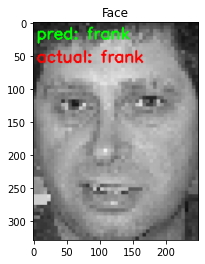

[INFO] prediction: allen, actual: jacques, confidence: 208.42


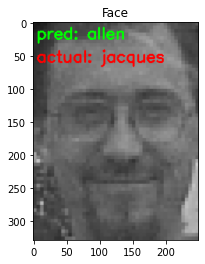

[INFO] prediction: gloria, actual: abraham, confidence: 171.67


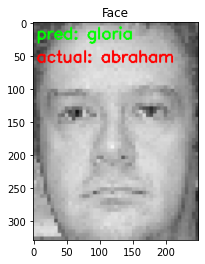

[INFO] prediction: raymond, actual: raymond, confidence: 178.35


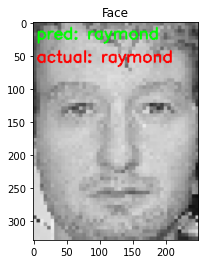

[INFO] prediction: carmen, actual: carmen, confidence: 182.36


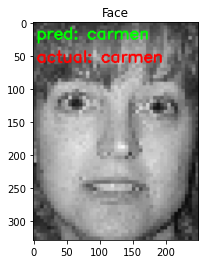

[INFO] prediction: jacques, actual: jacques, confidence: 163.15


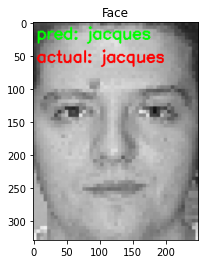

[INFO] prediction: mae, actual: mae, confidence: 164.52


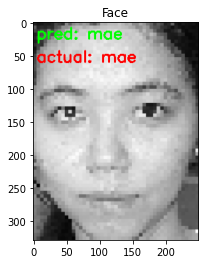

[INFO] prediction: raymond, actual: raymond, confidence: 185.92


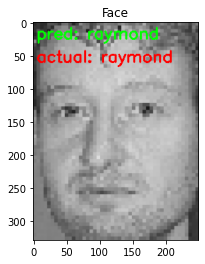

[INFO] prediction: frank, actual: frank, confidence: 167.65


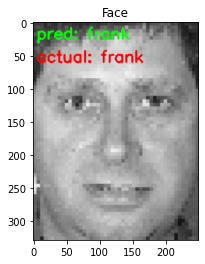

[INFO] prediction: cynthia, actual: cynthia, confidence: 171.19


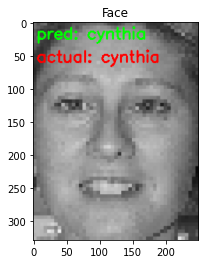

In [11]:
# generate a sample of testing data
idxs = np.random.choice(range(0, len(testY)), size=10, replace=False)

# loop over a sample of the testing data
for i in idxs:
	# grab the predicted name and actual name
	predName = le.inverse_transform([predictions[i]])[0]
	actualName = le.classes_[testY[i]]

	# grab the face image and resize it such that we can easily see
	# it on our screen
	face = np.dstack([testX[i]] * 3)
	face = imutils.resize(face, width=250)

	# draw the predicted name and actual name on the image
	cv2.putText(face, "pred: {}".format(predName), (5, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
	cv2.putText(face, "actual: {}".format(actualName), (5, 60),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

	# display the predicted name, actual name, and confidence of the
	# prediction (i.e., chi-squared distance; the *lower* the distance
	# is the *more confident* the prediction is)
	print("[INFO] prediction: {}, actual: {}, confidence: {:.2f}".format(
		predName, actualName, confidence[i]))

	# display the current face to our screen
	plt_imshow("Face", face)